# General Imports:

In [2]:
!pip uninstall -y numpy scipy gensim tensorflow
!pip install numpy==1.23.5 scipy==1.10.1 gensim==4.3.1 tensorflow==2.12.0

Found existing installation: numpy 1.24.3
Uninstalling numpy-1.24.3:
  Successfully uninstalled numpy-1.24.3
Found existing installation: scipy 1.10.1
Uninstalling scipy-1.10.1:
  Successfully uninstalled scipy-1.10.1
Found existing installation: gensim 4.3.1
Uninstalling gensim-4.3.1:
  Successfully uninstalled gensim-4.3.1
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
  Using cached scipy-1.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
  Using cached gensim-4.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.4 kB)
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from google.colab import drive

from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re

#from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt_tab")
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from gensim.models import KeyedVectors
import gensim.downloader as api
import random
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [31]:
SEED =42

# Python, NumPy, TensorFlow
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# 1. Data Import

In [2]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_path = "/content/drive/MyDrive/Text Mining/Data/train.csv"
test_path = "/content/drive/MyDrive/Text Mining/Data/test.csv"

In [4]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

<hr>

# 2. EDA - General Understanding of the Dataset

In [28]:
df_train.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [11]:
df_train.count()

,0
text,9543
label,9543


### 2.1 Target Feature Analysis:

In [13]:
df_train["label"].nunique()

3

In [14]:
df_train["label"].value_counts()

,count
label,
2,6178
1,1923
0,1442


In [22]:
df_train[df_train["label"] == 2].count()/len(df_train)

,0
text,0.647386
label,0.647386


- Imbalance: 64% of our occurences are labeled as "2". So there is some imbalance present in the dataset.

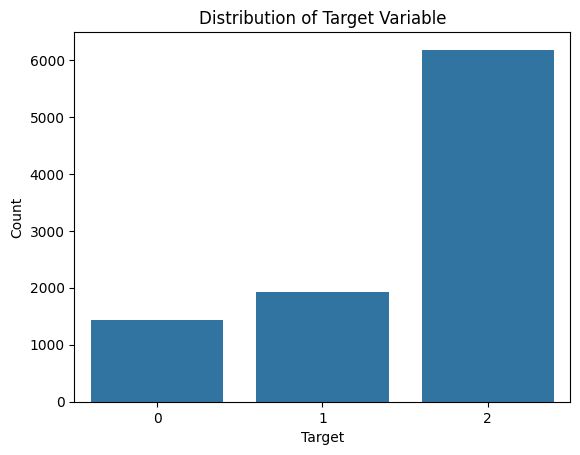

In [23]:
sns.countplot(data=df_train, x='label')
plt.title("Distribution of Target Variable")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

#### What represents 0/1/2 in our target Feature?

According to the Metadata:
- 0: Bearish Scenario
- 1: Bullish
- 2: Neutral

In [24]:
df_train["label"].isna().sum()

np.int64(0)

## 2.2 Text Analysis (Independent Features)

In [25]:
### Checking random piece of text from our corpora.
df_train["text"][5]

'$FTI - TechnipFMC downgraded at Berenberg but called Top Pick at Deutsche Bank https://t.co/XKcPDilIuU'

In [26]:
df_train["label"][5]

np.int64(0)

- This particular piece of text chosen at random was classified as 0 -> Bearish.
- Perhaps word "downgraded" had an impact in classifying this piece of text.

#### Word Count:

In [29]:
df_train['word_count']  = df_train['text'].apply(lambda x: len(str(x).split(" ")))
df_train[['text','word_count']].head()

,text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10
1,$CCL $RCL - Nomura points to bookings weakness...,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14
3,$ESS: BTIG Research cuts to Neutral https://t....,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10


In [30]:
df_train["word_count"].describe()

,word_count
count,9543.000000
mean,12.168081
std,4.651245
min,1.000000
25%,9.000000
50%,11.000000
75%,15.000000
max,31.000000


- Mean of 12 words per row.
- 31 words was the maximum word count.
- Minimum was 1 word, which we should check if these are relevant for our case.
- Most rows are comprised between 9 and 15 words.

In [32]:
df_train[df_train["word_count"] == 1]

,text,label,word_count
1858,SASA聚酯选用英威达PTA技术,2,1
3943,:),2,1
3948,@TicToc,2,1
4360,Damn,2,1
4440,F5,2,1
4681,https://t.co/575AH1YRkF,2,1
4682,https://t.co/9eZPvQhfMq,2,1
4683,https://t.co/oJxNPEUpWq,2,1
5505,Wipro赢得Marelli的多年战略性IT协议,2,1
8290,$TSLA,2,1


Insights:
- Most rows are simply stock tickers, or a URL or emoji, or non-informative token...
- Removing these rows could be interesting, we could reduce noice, avoid overfitting to rare or meaningless terms.
- We can try to use models where we include these rows, some models might benefit from this other might not. We will iteratively try this and come back to this later.

Yet its important to note that rows that are just tickers, and are labeled as "positive" does not seem right...

In [37]:
df_train[df_train["word_count"] == 2]

,text,label,word_count
3090,Brent +4%,1,2
3945,@MikeCaymanTrades sometimes,2,2
3980,100% Correct!,2,2
4914,Next week.,2,2
5484,Wholesale Trade,2,2
5512,Woke Sachs,2,2
5654,$penn coin,2,2
6511,Housing Starts,2,2
7276,Kudlow https://t.co/owfUNJQzrb,2,2
7935,$WW heavy....,1,2


#### Length Distributions:

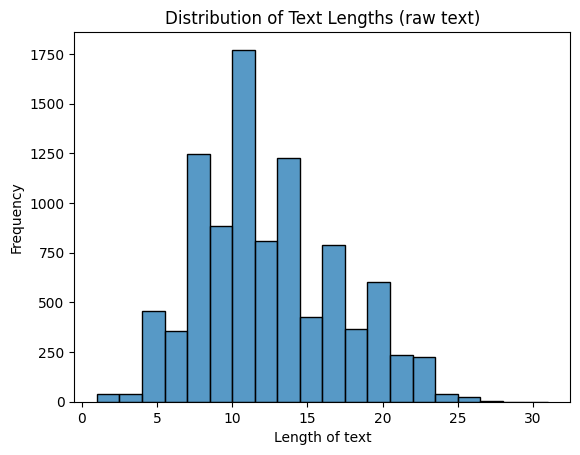

In [38]:
sns.histplot(df_train['word_count'], bins=20)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

#### Individual Words - Which ones are most prominent?

In [41]:
all_words = ' '.join(df_train['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:15]

,count
to,2332
the,1820
of,1464
-,1390
in,1361
on,1136
for,1032
a,970
and,898
The,663


- Naturally the most prominent words are stop words... Might be interesting to remove them in preprocessing as they do not carry much semantics.

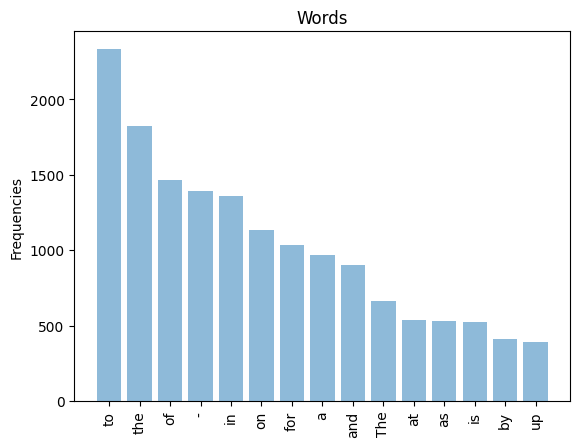

In [42]:
x_labels = freq.index[0:15]
values = freq[:15]
plt.bar(x_labels, values, align='center', alpha=0.5)
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

#### Rare Words

In [44]:
rare_words = ' '.join(df_train['text']).split()
freq = pd.Series(rare_words).value_counts()
freq.sort_values(ascending=True)[0:25]

,count
https://t.co/Xmu5o6jOYd,1
"""terrible""",1
Defensive,1
Supreme:,1
Reigns,1
Overstock,1
ads…,1
https://t.co/BSTzaP5OdB,1
https://t.co/Y1SH7aSxz9,1
https://t.co/SO1GpndMW4,1


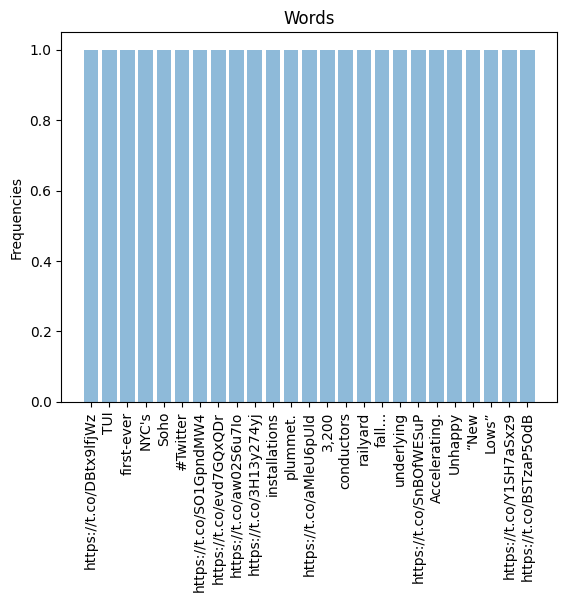

In [47]:
freq = freq.sort_values(ascending=True)
x_labels = freq.index[0:25]
values = freq[:25]
plt.bar(x_labels, values, align='center', alpha=0.5)
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

Most are URL's...
- Question: Can model's take information from URL..?

#### Class-wise Word Distributions - TOP words per Target Class

In [ ]:
#### CREATING CLEAN TEXT WITHOUT STOPWORDS FOR THIS ANALYSIS (TEMPROARY DF):

In [57]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [58]:
df_no_stopwords = df_train.copy()
df_no_stopwords['text'] = df_no_stopwords['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

CLASS 0:

In [60]:
df_train[df_train["label"] == 0]["text"] \
    .str.lower().str.split() \
    .explode() \
    .loc[lambda x: ~x.isin(stopwords)] \
    .value_counts() \
    .head(10)

,count
text,
-,210
stock,130
misses,85
u.s.,79
coronavirus,72
oil,67
price,63
market,63
shares,61


CLASS 1:

In [61]:
df_train[df_train["label"] == 1]["text"] \
    .str.lower().str.split() \
    .explode() \
    .loc[lambda x: ~x.isin(stopwords)] \
    .value_counts() \
    .head(10)

,count
text,
-,317
stock,231
beats,161
price,132
target,116
shares,110
u.s.,106
revenue,102
new,95


CLASS 2:

In [62]:
df_train[df_train["label"] == 2]["text"] \
    .str.lower().str.split() \
    .explode() \
    .loc[lambda x: ~x.isin(stopwords)] \
    .value_counts() \
    .head(10)

,count
text,
-,863
:,343
results,307
#stock,283
new,282
earnings,239
2019,225
dividend,224
reports,222


Note: We have a lot of -, this likely does not carry much information.

N-Gram Analysis:

In [52]:
trigram_vectorizer = CountVectorizer(ngram_range=(3,3), max_features=30)
X_trigrams = trigram_vectorizer.fit_transform(df_train["text"])
print(trigram_vectorizer.get_feature_names_out())

['19 00pm gmt' 'alpha https co' 'beats on revenue' 'call or presentation'
 'conference call or' 'dividend https co' 'earnings conference call'
 'economy marketscreener https' 'edited transcript of' 'eps beats by'
 'eps misses by' 'hedge funds are' 'marketscreener https co'
 'misses on revenue' 'more https co' 'on revenue https' 'on seeking alpha'
 'price target raised' 'read more and' 'reading https co'
 'reports q3 results' 'results earnings call' 'revenue https co'
 'seeking alpha https' 'sign up for' 'stock https co'
 'stock market update' 'stock marketscreener https' 'stock price target'
 'target raised to']


- Many Trigrams include https; likely not semantically helpful.
- There are several financial phrases that could be strong indicators for certain classes.

#### Character Level Patterns: Digits/Punctuation/ Emojis/ URLs

In [66]:
# Count digits
df_train["digit_count"] = df_train["text"].str.count(r"\d")

# Count punctuation
df_train["punct_count"] = df_train["text"].str.count(r"[^\w\s]")

# Count uppercase words
df_train["upper_count"] = df_train["text"].str.findall(r"\b[A-Z]{2,}\b").str.len()

#URL
df_train["has_url"] = df_train["text"].str.contains(r"http\S+", regex=True)
# Mentions
df_train["has_mention"] = df_train["text"].str.contains(r"@\w+", regex=True)
# Hashtags
df_train["has_hashtag"] = df_train["text"].str.contains(r"#\w+", regex=True)

# Detect emojis (optional but cool)
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
df_train["emoji_count"] = df_train["text"].apply(lambda x: len(emoji_pattern.findall(x)))


In [67]:
df_train[["digit_count", "punct_count", "upper_count", "emoji_count"]].describe()

,digit_count,punct_count,upper_count,emoji_count
count,9543.000000,9543.000000,9543.000000,9543.000000
mean,2.250655,5.671382,0.724301,0.002829
std,2.605929,4.615066,1.296677,0.055056
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,0.000000
50%,2.000000,5.000000,0.000000,0.000000
75%,4.000000,9.000000,1.000000,0.000000
max,35.000000,28.000000,23.000000,2.000000


In [71]:
df_train.groupby("label")[["digit_count", "punct_count", "upper_count", "emoji_count"]].mean()

,digit_count,punct_count,upper_count,emoji_count
label,,,,
0,2.123440,5.269071,0.657420,0.000000
1,2.664067,5.515341,0.798232,0.000520
2,2.151667,5.813856,0.716899,0.004208


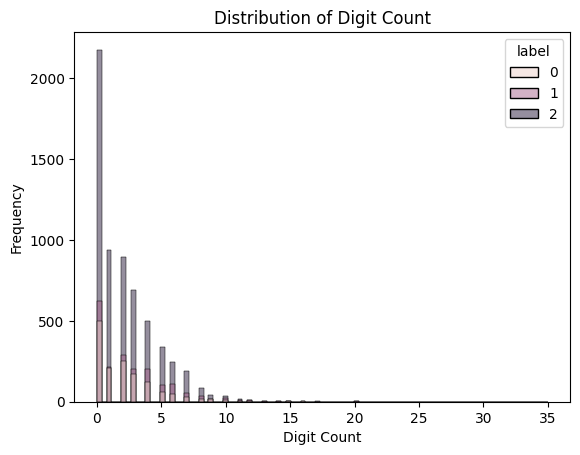

In [76]:
sns.histplot(data=df_train, x="digit_count", hue="label")
plt.title("Distribution of Digit Count")
plt.xlabel("Digit Count")
plt.ylabel("Frequency")
plt.show()


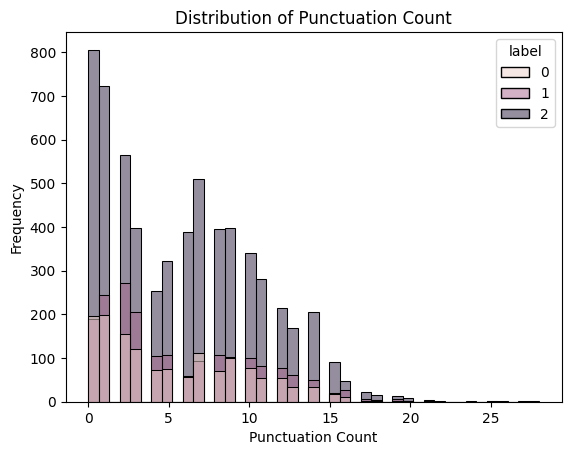

In [78]:
sns.histplot(data=df_train, x="punct_count", hue="label")
plt.title("Distribution of Punctuation Count")
plt.xlabel("Punctuation Count")
plt.ylabel("Frequency")
plt.show()

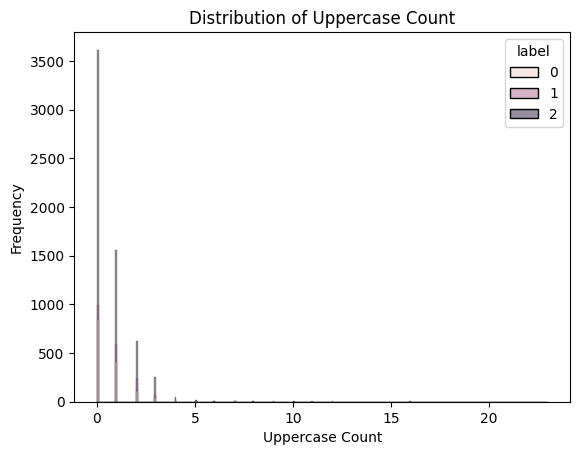

In [79]:
sns.histplot(data=df_train, x="upper_count", hue="label")
plt.title("Distribution of Uppercase Count")
plt.xlabel("Uppercase Count")
plt.ylabel("Frequency")
plt.show()

In [81]:
df_train.groupby("label")[["has_url", "has_mention", "has_hashtag"]].mean()

,has_url,has_mention,has_hashtag
label,,,
0,0.443135,0.020804,0.067961
1,0.391056,0.016121,0.061882
2,0.498381,0.037714,0.109906


- Positive Labels tend to have less URLs/Mentions/ and Hashtags

<hr>

# 3. Preprocessing

## 3.1 Initial Analysis - Recollection of insights from EDA

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train["text"], df_train["label"], test_size=0.2, stratify=df_train["label"], random_state=42)

- URLS: Most URLS dont carry meaning. We can indicate that to the model by replacing the URL with something like "URL".

- MENTIONS: Same

- Hashtags: Words in the # might be insightful, yet the # itself is not relevant, same for punctuation.

- Punctuation: ! or ? Could be insightful as it expresses sentiment or doubt or excitment. Yet things like =, -, _ are not as relevant

- Lowercasing : Necessary

## 3.2 Basic Cleaning:

In [9]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [10]:
def full_preprocess(text):
    # ─── STEP 1: BASIC CLEANING ───
    text = re.sub(r"http\S+|www\S+", "<URL>", text)          # Replace URLs
    text = re.sub(r"@\w+", "<USER>", text)                   # Replace mentions
    text = re.sub(r"#", "", text)                            # Remove hashtag symbol
    text = re.sub(r"[^\w\s!?\.]", " ", text)                 # Remove punctuation selectively
    text = text.lower()                                      # Lowercase
    text = re.sub(r"\s+", " ", text).strip()                 # Normalize spaces

    # ─── STEP 2: TOKENIZATION ───
    tokens = nltk.word_tokenize(text)

    # ─── STEP 3: REMOVE STOPWORDS ───
    tokens = [word for word in tokens if word not in stop_words]

    # ─── STEP 4: LEMMATIZATION ───
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # ─── STEP 5: STEMMING ───
    tokens = [stemmer.stem(word) for word in tokens]

    return tokens

In [11]:
X_train_tokens = X_train.apply(full_preprocess)
X_test_tokens = X_test.apply(full_preprocess)


In [15]:
X_train_tokens.head()

,text
2186,"[nasdaq, price, 600m, 0.875, senior, note]"
6819,"[futur, url]"
6157,"[econx, novemb, nonfarm, privat, payrol, 125k,..."
2462,"[twitter, user, explain, kohl, stock, got, obl..."
4097,"[agilysi, restaur, find, sustain, method, limi..."


In [16]:
X_train_tokens[0]

['bynd', 'jpmorgan', 'reel', 'expect', 'beyond', 'meat', 'url']

# 4. Feature Engineering

## 4.1 Feature Engineering - BoW + KNN

In [34]:
X_train_text = [" ".join(tokens) for tokens in X_train_tokens]
X_test_text = [" ".join(tokens) for tokens in X_test_tokens]

bow = CountVectorizer(binary=True)
X_train_bow = bow.fit_transform(X_train_text)
X_test_bow = bow.transform(X_test_text)

In [35]:
X_train_bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 67631 stored elements and shape (7634, 10823)>

In [22]:
print(bow.get_feature_names_out()[1000:1050])

['amor' 'amorim' 'amount' 'amp' 'ampl' 'amput' 'amrh' 'amrn' 'amset' 'amt'
 'amtac' 'amtd' 'amwd' 'amyotroph' 'amza' 'amzn' 'anab' 'anal' 'analog'
 'analysi' 'analyst' 'analytica' 'analyz' 'anaptysbio' 'anchor' 'ancora'
 'andacollo' 'andaman' 'andaz' 'andreessen' 'andrew' 'anesthesia' 'anet'
 'anf' 'angel' 'angela' 'angeloakcap' 'anger' 'angiodynam' 'angl' 'anglo'
 'angloamerican' 'angloaustralianresourcesnl' 'anglogold' 'ango' 'angola'
 'angolan' 'angrick' 'anheus' 'anheuserbuschinbev']


#### Top BoW Words - Cleaned

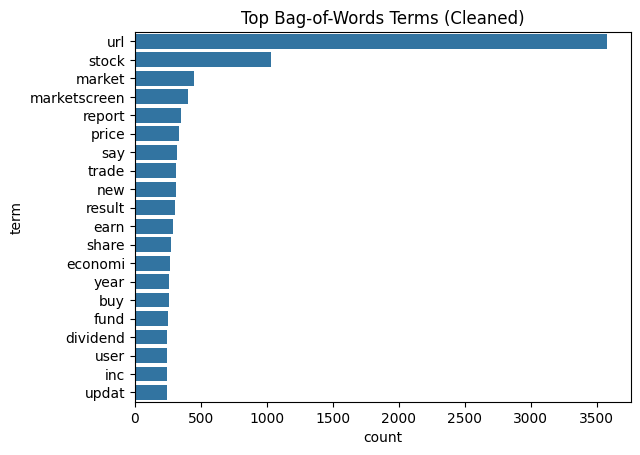

In [23]:
# 🔍 Visualize top Bag of Words terms (Cleaned)
clean_bow_sum = np.array(X.sum(axis=0)).flatten()
clean_terms = bow.get_feature_names_out() # in older versions is get_feature_names()
clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum}).sort_values(by='count', ascending=False).head(20)

sns.barplot(data=clean_top, x='count', y='term')
plt.title("Top Bag-of-Words Terms (Cleaned)")
plt.show()

In [25]:
#### Defining Labels
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [26]:
y_train[0]

np.int64(0)

#### Classifier - KNN

In [36]:
modelknn = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')

In [37]:
modelknn.fit(X_train_bow,y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')

In [38]:
preds = modelknn.predict(X_test_bow)

In [41]:
#### Evaluate
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(preds, y_test, target_names = labels.keys()))


              precision    recall  f1-score   support

     Bearish       0.35      0.72      0.47       138
     Bullish       0.55      0.71      0.62       301
     Neutral       0.94      0.79      0.86      1470

    accuracy                           0.77      1909
   macro avg       0.61      0.74      0.65      1909
weighted avg       0.84      0.77      0.79      1909



In [42]:
confusion_matrix(preds, y_test)

array([[ 100,   14,   24],
       [  40,  213,   48],
       [ 148,  158, 1164]])

<hr>

## 4.2 Word2Vec + LSTM

In [6]:
def preprocess_for_w2v(text):
    text = re.sub(r"http\S+|www\S+", "", text)       # Remove URLs
    text = re.sub(r"[^\w\s]", "", text)              # Remove punctuation
    text = text.lower().strip()
    return nltk.word_tokenize(text)

In [7]:
X_train_tokens_2 = X_train.apply(preprocess_for_w2v)
X_test_tokens_2 = X_test.apply(preprocess_for_w2v)


In [11]:
#### Twitter-style embeddings (good for social/financial text)
w2v = api.load("glove-twitter-200")

In [19]:
embedding_dim = w2v.vector_size

In [14]:
train_len = []
for i in X_train_tokens_2:
    train_len.append(len(i))

In [16]:
max(train_len)

31

In [17]:
X_train_text = [" ".join(tokens) for tokens in X_train_tokens_2]
X_test_text = [" ".join(tokens) for tokens in X_test_tokens_2]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_text)

X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

# Pad sequences
maxlen = 31
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

In [20]:
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in w2v:
        embedding_matrix[i] = w2v[word]

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=False))  # keep embeddings fixed

model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [55]:
history = model.fit(
    X_train_pad,
    y_train,
    epochs=7,
    batch_size=32,
    validation_split=0.2,
    shuffle = True
)


Epoch 1/7
191/191 [==============================] - 107s 133ms/step - loss: 0.8036 - accuracy: 0.6702 - val_loss: 0.6568 - val_accuracy: 0.7243
Epoch 2/7
191/191 [==============================] - 22s 117ms/step - loss: 0.6584 - accuracy: 0.7249 - val_loss: 0.5913 - val_accuracy: 0.7649
Epoch 3/7
191/191 [==============================] - 20s 107ms/step - loss: 0.5869 - accuracy: 0.7596 - val_loss: 0.5660 - val_accuracy: 0.7904
Epoch 4/7
191/191 [==============================] - 22s 116ms/step - loss: 0.5262 - accuracy: 0.7986 - val_loss: 0.5585 - val_accuracy: 0.7839
Epoch 5/7
191/191 [==============================] - 20s 106ms/step - loss: 0.4661 - accuracy: 0.8210 - val_loss: 0.5294 - val_accuracy: 0.7917
Epoch 6/7
191/191 [==============================] - 22s 115ms/step - loss: 0.4093 - accuracy: 0.8410 - val_loss: 0.5341 - val_accuracy: 0.7904
Epoch 7/7
191/191 [==============================] - 20s 107ms/step - loss: 0.3553 - accuracy: 0.8718 - val_loss: 0.5480 - val_accuracy

In [57]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


60/60 [==============================] - 2s 28ms/step - loss: 0.5894 - accuracy: 0.7805
Test Accuracy: 0.7805


# 5. BERT/FINBERT - Different Pipeline:

In [ ]:
from transfomers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [9]:
# --- Imports ---
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import re

# --- 1. Load & Preprocess Data ---

def minimal_clean(text):
    text = re.sub(r"http\S+", "<URL>", text)
    text = re.sub(r"@\w+", "<USER>", text)
    text = re.sub(r"#", "", text)  # Keep hashtag word
    return text.strip()

# df must contain 'text' and 'label' columns
df_train["clean_text"] = df_train["text"].apply(minimal_clean)
X_train, X_test, y_train, y_test = train_test_split(
    df_train["clean_text"], df_train["label"], stratify=df_train["label"], test_size=0.2, random_state=42
)

train_df = pd.DataFrame({"text": X_train, "label": y_train})
test_df = pd.DataFrame({"text": X_test, "label": y_test})

# --- 2. Convert to HuggingFace Dataset ---
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

# --- 3. Tokenize ---
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

train_ds = train_ds.map(tokenize_fn, batched=True)
test_ds = test_ds.map(tokenize_fn, batched=True)

# --- 4. Load Model ---
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# --- 5. Metrics Function ---
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
        "f1": f1_score(labels, preds, average="macro")
    }

# --- 6. Training Arguments ---
training_args = TrainingArguments(
    output_dir="./finbert_output",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=False,
    report_to="none"  # disables wandb/tensorboard
)

# --- 7. Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

# --- 8. Train ---
trainer.train()

# --- 9. Evaluate ---
eval_results = trainer.evaluate()
print(eval_results)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Step,Training Loss
10,3.454900
20,0.712200
30,0.828000
40,0.674700
50,0.724300
60,0.828900
70,0.783400
80,0.761200
90,0.597500
100,0.689400


Step,Training Loss
10,3.454900
20,0.712200
30,0.828000
40,0.674700
50,0.724300
60,0.828900
70,0.783400
80,0.761200
90,0.597500
100,0.689400


{'eval_loss': 0.38346683979034424, 'eval_accuracy': 0.855945521215296, 'eval_precision': 0.8232267085219737, 'eval_recall': 0.7887529945782372, 'eval_f1': 0.8043044516295635, 'eval_runtime': 811.0726, 'eval_samples_per_second': 2.354, 'eval_steps_per_second': 0.148, 'epoch': 1.0}
